In [1]:
%matplotlib
%pylab inline
from functools import reduce
import seaborn as sns
import pandas as pd
import numpy as np
mpl.rcParams['font.family'] = 'Times New Roman'

Using matplotlib backend: <object object at 0x1118cb440>
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
conditions = ['15C', 'No Treatment']  # list of conditions to process - Change

main_dir = '/Users/violahalder/Desktop/GitHub_GI_Analysis'  # main directory path - Change
genes_path = f'{main_dir}/files/geneNames.csv'

In [3]:
# Get unique gene list
df_genes = pd.read_csv(genes_path, header=None)
genes_single = list(df_genes[1].values)

### Fitness score and Genetic Interaction score heatmaps

In [4]:
fitness_data = []
single_fitness_data = []
gi_data = []
for cdn in conditions:
    print(f'processing condition: {cdn}')
    
    # set output paths
    fitness_heatmap_outpath = f'{main_dir}/output_figures/{cdn}_Fitness_Score_heatmap.png'
    gi_heatmap_outpath = f'{main_dir}/output_figures/{cdn}_Genetic_Interaction_heatmap.png'
    
    # load average fitness and eps scores
    eps_path = f'{main_dir}/output/{cdn}_fitness_and_eps.xlsx'
    df_eps = pd.read_excel(eps_path, sheet_name='Average').fillna('')
    df_eps['Genes'] = df_eps['Gene_X'] + ' / ' + df_eps['Gene_Y']
        
    # save Double Deletion Mutant fitness and GI data to compiled dataframe
    fitness_data.append(df_eps[['Genes', 'Average_Fitness_XY_Fitness_YX']].rename(columns={'Average_Fitness_XY_Fitness_YX': f'Average_Fitness_XY_Fitness_YX_{cdn}'}))
    gi_data.append(df_eps[['Genes', 'Average_EPS_XY_EPS_YX']].rename(columns={'Average_EPS_XY_EPS_YX': f'Average_EPS_XY_EPS_YX_{cdn}'}))
    
    # initialize Fitness score and GI dataframes
    df_fitness = pd.DataFrame(np.nan, index=genes_single, columns=genes_single)
    df_gi = pd.DataFrame(np.nan, index=genes_single, columns=genes_single)
    
    # populate final Fitness score and GI heatmap dataframes
    for gene_x, gene_y, _, _, _, _, _, _, avg_fitness, avg_gi, _ in df_eps.itertuples(index=False):
        if avg_fitness:
            df_fitness.at[gene_x, gene_y] = avg_fitness
        if avg_gi:
            df_gi.at[gene_x, gene_y] = avg_gi
            
    # add Single Deletion Mutant fitness data to heatmap dataframe
    single_deletion_scores = {'Genes': [], f'Single_Fitness_Score_{cdn}': []}
    for gene in genes_single:
        try:
            avg_fitness_single = df_eps[df_eps['Gene_X']==gene]['Fitness_X'].values[0]
        except IndexError:
            avg_fitness_single = df_eps[df_eps['Gene_Y']==gene]['Fitness_Y'].values[0]
        df_fitness.at[gene, gene] = avg_fitness_single
        single_deletion_scores['Genes'].append(gene)
        single_deletion_scores[f'Single_Fitness_Score_{cdn}'].append(avg_fitness_single)
    single_fitness_data.append(pd.DataFrame.from_dict(single_deletion_scores))
    
    # plot and save Fitness score heatmap - editable based on preference
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(df_fitness,
                cmap='RdBu_r', 
                cbar_kws={'shrink': 0.5}, 
                square=True,
                vmin=0,
                vmax=2,
                ax=ax, annot_kws={"size": 20})
    ax.set_facecolor('gray')
    ax.set_title(f'Fitness score heatmap for {cdn}', pad=7, fontsize=16)
    cbar = ax.collections[0].colorbar
    cbar.set_label('Fitness score', labelpad=-49, fontsize=12)
    plt.tight_layout()
    plt.savefig(fitness_heatmap_outpath, dpi=300, bbox_inches='tight')
    plt.close(fig) # Can comment out to see in browser
    
    # plot and save GI heatmap - editable based on preference
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(df_gi, 
                cmap='RdBu_r', 
                cbar_kws={'shrink': 0.5}, 
                square=True, 
                vmin=-1,
                vmax=1,
                center=0,
                ax=ax, annot_kws={"size": 20})
    ax.set_facecolor('gray')
    ax.set_title(f'Genetic Interaction score heatmap for {cdn}', pad=7, fontsize=16)
    cbar = ax.collections[0].colorbar
    cbar.set_label('Genetic Interaction score', labelpad=-55, fontsize=12)
    plt.tight_layout()
    plt.savefig(gi_heatmap_outpath, dpi=300, bbox_inches='tight')
    plt.close(fig) # Can comment out to see in browser


processing condition: 15C
processing condition: No Treatment


### Single deletion fitness score heatmap

In [5]:
df_all_single_fitness = reduce(lambda left, right: pd.merge(left, right, on=['Genes'], 
                                                how='outer'), single_fitness_data)
df_all_single_fitness.set_index('Genes', inplace=True)
df_all_single_fitness.replace('', np.nan, inplace=True)
df_all_single_fitness.columns = conditions
df_all_single_fitness[:1]

,15C,No Treatment
Genes,,
CAT1,1.384797,0.992855


In [6]:
# plot and save Single Deltion Fitness score heatmap - editable based on preference
single_fitness_heatmap_outpath = f'{main_dir}/output_figures/Single_Deletion_Fitness_Score_heatmap.png'
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_all_single_fitness,
            cmap='RdBu_r', 
            cbar_kws={'shrink': 0.5}, 
            square=True,
            vmin=0,
            vmax=2,
            ax=ax, annot_kws={"size": 16})
ax.set_facecolor('gray')
ax.set_title('Single Deletion Fitness Score heatmap', pad=16, fontsize=16)
cbar = ax.collections[0].colorbar
cbar.set_label('Fitness score', labelpad=-60, fontsize=14)
plt.tight_layout()
plt.savefig(single_fitness_heatmap_outpath, dpi=300, bbox_inches='tight')
plt.close(fig) # Can comment out to see in browser

### Significant data heatmap

In [7]:
significant_data = []
for cdn in conditions:
    print(f'processing condition: {cdn}')
    
    # set output path
    significant_heatmap_outpath = f'{main_dir}/output_figures/{cdn}_Significant_data_heatmap.png'
    
    # load significant data
    sig_path = f'{main_dir}/output/{cdn}_pvalue_compiled.csv'
    df_sig = pd.read_csv(sig_path).fillna(np.nan)
    
    # initialize significant heatmap dataframe
    df_significant = pd.DataFrame(np.nan, index=genes_single, columns=genes_single)
    
    # populate final significant heatmap dataframe
    for gene_x, gene_y, _, _, _, _, _, _, _, _, sig_val in df_sig.itertuples(index=False):
        try:
            df_significant.at[gene_x, gene_y] = sig_val
        except ValueError:
            continue

    # add Single Deletion Mutant data to heatmap dataframe; set to None
    for gene in genes_single:
        df_significant.at[gene, gene] = None
        
    # plot and save significant score heatmap
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(df_significant,
                cmap='bwr', 
                cbar_kws={'shrink': 0.5}, 
                square=True,
                vmin=-1,
                vmax=1,
                ax=ax, 
                linewidths=0.2,
                linecolor='gray', annot_kws={"size": 16})
    ax.set_facecolor('gray')
    ax.set_title(f'Significant data heatmap for {cdn}', pad=10, fontsize=16)
    cbar = ax.collections[0].colorbar
    cbar.set_label('Significant data', labelpad=-44, fontsize=12)
    cbar.set_ticks([-1, 0, 1])
    plt.tight_layout()
    plt.savefig(significant_heatmap_outpath, dpi=300, bbox_inches='tight')
    plt.close(fig) # Can comment out to see in browser


processing condition: 15C
processing condition: No Treatment


In [8]:
plt.close()
print("DONE")

DONE


### Fitness score and Genetic Interaction score clustering

In [9]:
# Fitness score clustering 
df_all_fitness = reduce(lambda left, right: pd.merge(left, right, on=['Genes'], 
                                                how='outer'), fitness_data)
df_all_fitness.set_index('Genes', inplace=True)
df_all_fitness.replace('', np.nan, inplace=True)
df_all_fitness.dropna(how='any', inplace=True)
df_all_fitness.columns = conditions

# Append single deletetion fitness data
df_all_fitness_include_single = pd.concat([df_all_fitness, df_all_single_fitness])
df_all_fitness_include_single[:1]

,15C,No Treatment
Genes,,
TYE7 / CAT1,0.486279,0.971586


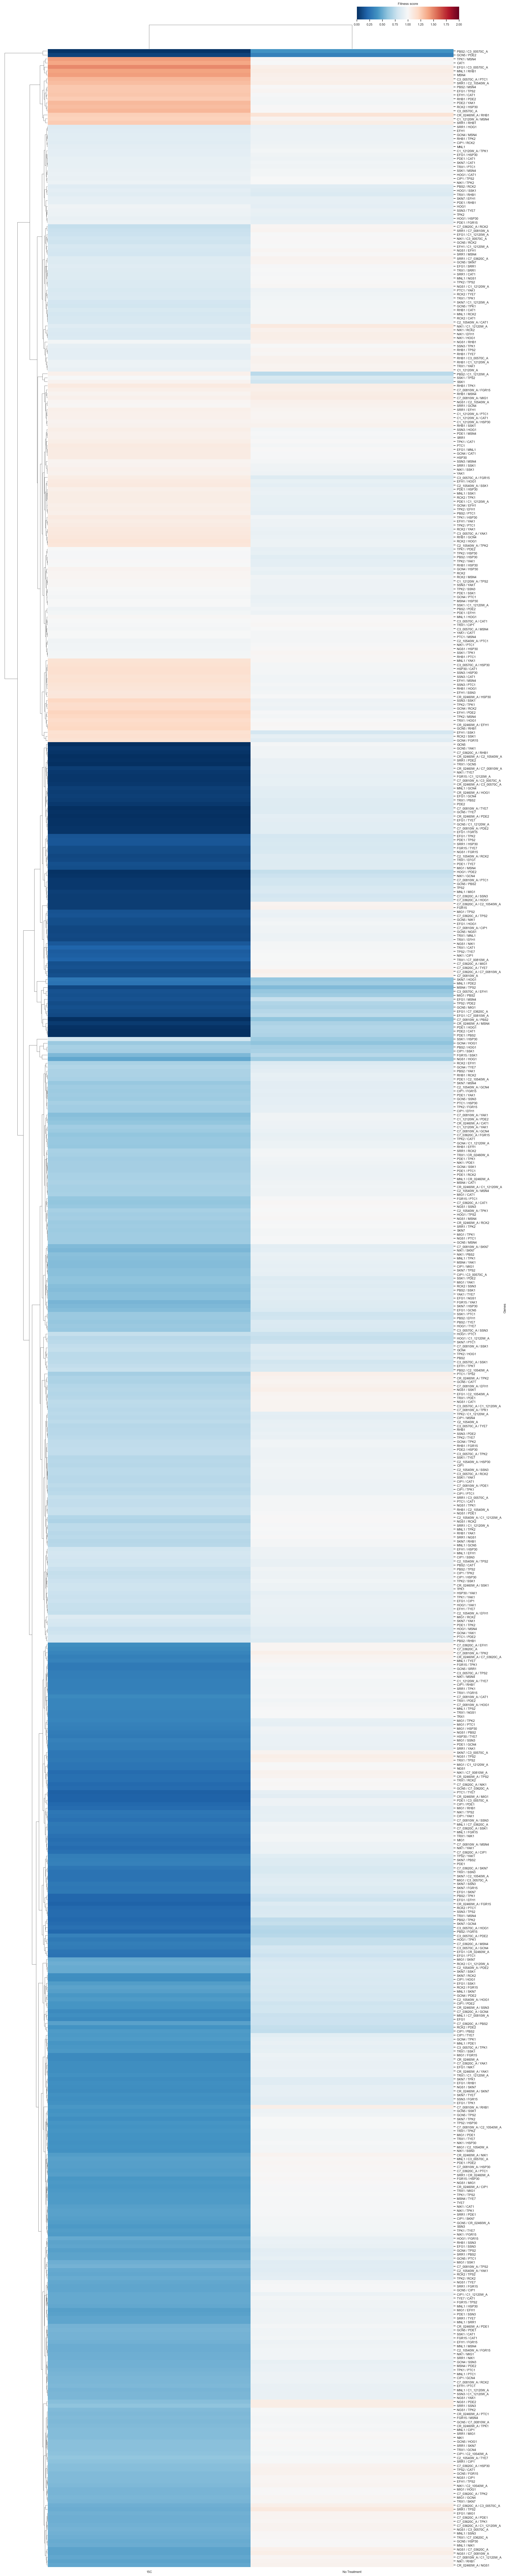

In [10]:
# editable based on preference
sns.set(font_scale=0.8)
sns.set_style('white')

g = sns.clustermap(df_all_fitness_include_single, 
                   cmap='RdBu_r', 
                   figsize=(20,100),
                   cbar_kws={'orientation': 'horizontal'},
                   xticklabels=True,
                   yticklabels=True,
                   vmin=0,
                   vmax=2,
                   dendrogram_ratio=(0.1, 0.01),
                  )

x0, _y0, _w, _h = g.cbar_pos
g.ax_cbar.set_position([0.7, 1.0001, 0.2, 0.005])
g.ax_cbar.set_title('Fitness score')

fitness_clustermap_outpath = f'{main_dir}/output_figures/All_cdn_Fitness_Score_clustermap.png'
g.savefig(fitness_clustermap_outpath, dpi=300, bbox_inches='tight')

In [11]:
# Genetic interaction clustering
df_all_gi = reduce(lambda left, right: pd.merge(left, right, on=['Genes'], 
                                                how='outer'), gi_data)
df_all_gi.set_index('Genes', inplace=True)
df_all_gi.replace('', np.nan, inplace=True)
df_all_gi.dropna(how='any', inplace=True)
df_all_gi.columns = conditions
df_all_gi[:1]

,15C,No Treatment
Genes,,
TYE7 / CAT1,-0.105798,-0.009709


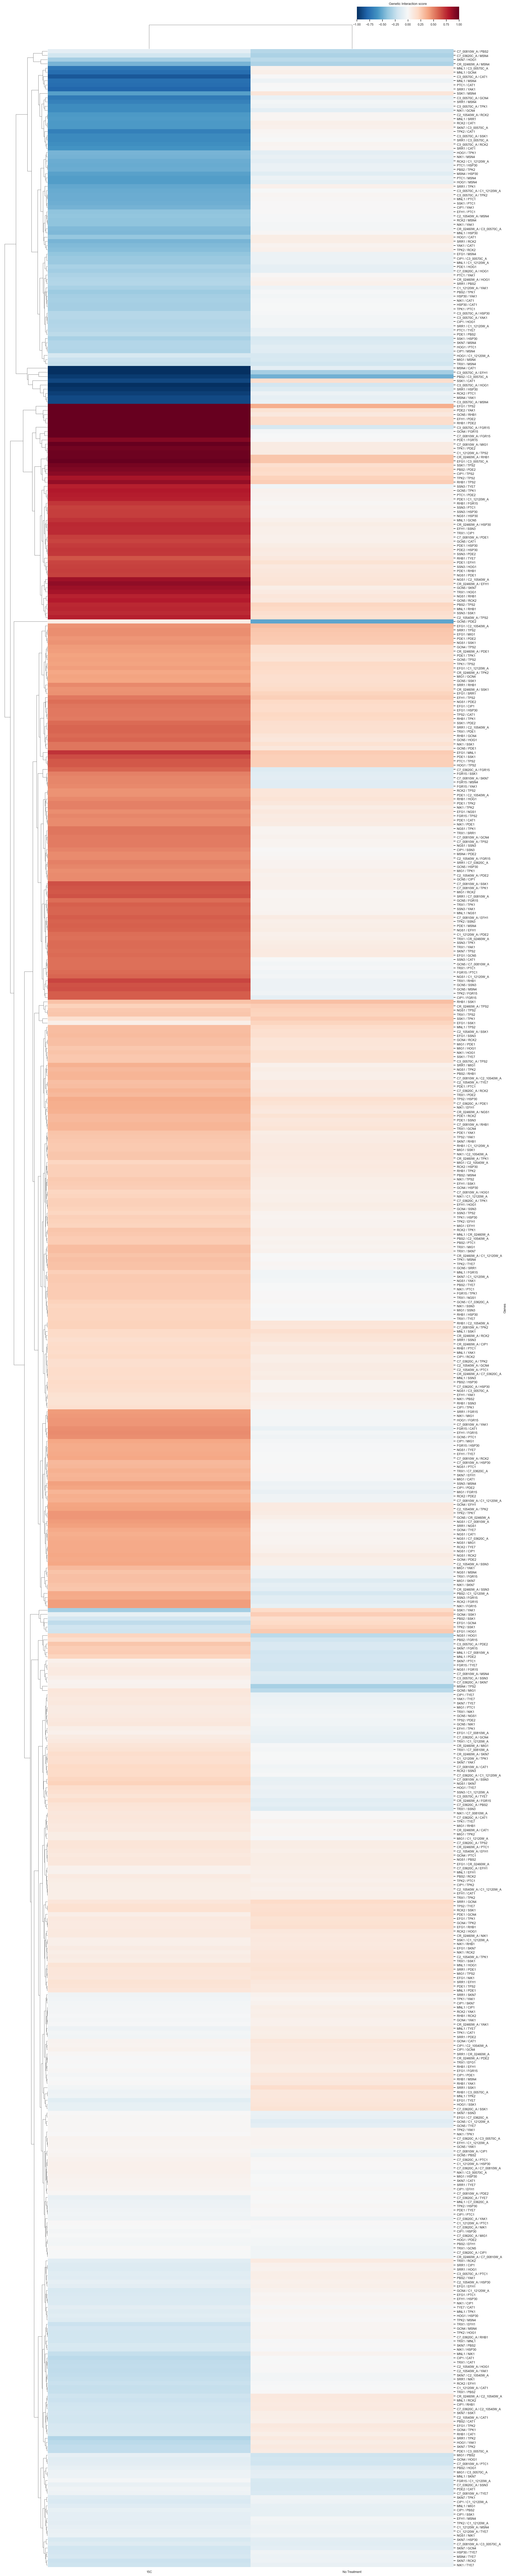

In [12]:
# editable based on preference
sns.set(font_scale=0.8)
sns.set_style('white')

g = sns.clustermap(df_all_gi, 
                   cmap='RdBu_r', 
                   figsize=(20,100),
                   cbar_kws={'orientation': 'horizontal'},
                   xticklabels=True,
                   yticklabels=True,
                   vmin=-1,
                   vmax=1,
                   center=0,
                   dendrogram_ratio=(0.1, 0.01),
                  )

x0, _y0, _w, _h = g.cbar_pos
g.ax_cbar.set_position([0.7, 1.0001, 0.2, 0.005])
g.ax_cbar.set_title('Genetic Interaction score')

gi_clustermap_outpath = f'{main_dir}/output_figures/All_cnd_Genetic_Interaction_clustermap.png'
g.savefig(gi_clustermap_outpath, dpi=300, bbox_inches='tight')